In [4]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"


# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import pymc3 as pm
theano.config.optimizer_including

from io import StringIO
import sys

import warnings
warnings.filterwarnings("ignore")

### Model creation:

In [8]:
# Data Preparation
path_to_data = os.pardir+"/../../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[10,1,10], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 
geo_data.delete_surfaces('rock1',remove_data=True)
geo_data.delete_surface_points([1,3,4,5])
geo_data.modify_surface_points([0, 2], Y=500, Z=[500, 600])

Active grids: ['regular']


,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,500,500,0.2501,0.5001,0.46885,rock2,Default series,1,1,1.000000e-08
2,900,500,600,0.7501,0.5001,0.53135,rock2,Default series,1,1,1.000000e-08


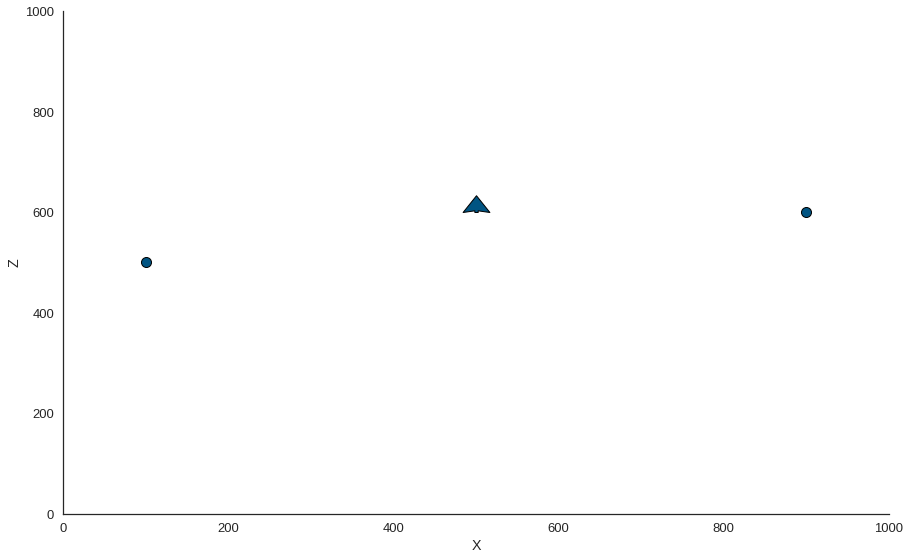

In [9]:
gp.plot.plot_data(geo_data)

In [10]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile',
                         verbose=['compare'])

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float32
Number of faults:  0
Compilation Done!


In [11]:
gp.compute_model(geo_data);

n_surface_0 __str__ = [[0.]]
a __str__ = 0.0
n_surface_1 __str__ = [[1.]]
b __str__ = 0.8123463
drift[slice_init:slice_init+1][0] __str__ = [[1.]]
n_surface_0 __str__ = [[2.]]
a __str__ = 0.8123463
n_surface_1 __str__ = [[0.]]
b __str__ = 0.0
drift[slice_init:slice_init+1][0] __str__ = [[2.]]


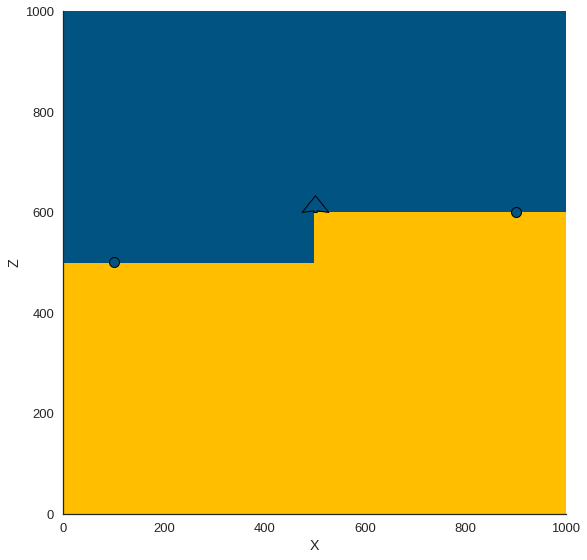

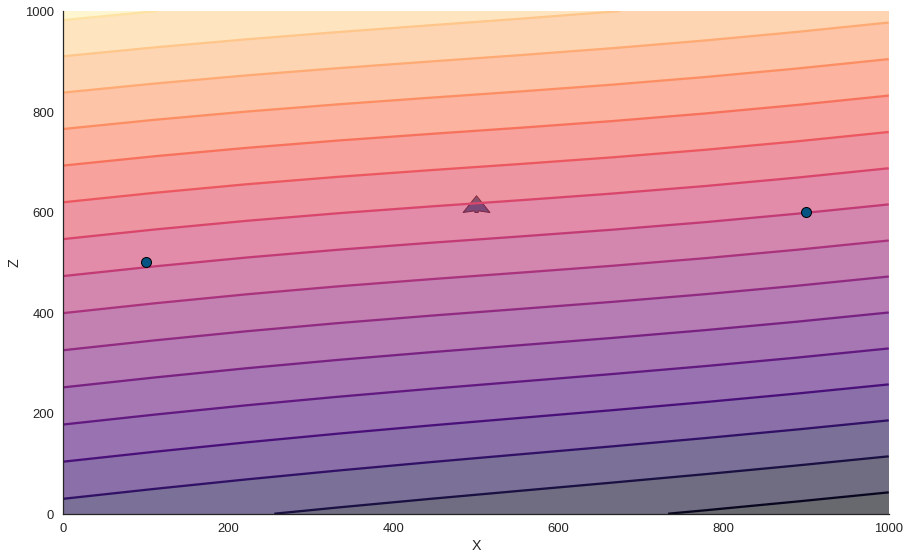

In [12]:
gp.plot.plot_section(geo_data, 0, show_data=True)
gp.plot.plot_scalar_field(geo_data, 0, plot_data=False)

## Plotting the sigmoid function:

To be able to calculate the gradient of a function the first step is to guarantee that the function is continuous. The interpolation functions used in geomodelling are a set of many algebraic operations and hence we would need to assure that each of these components is differentiable. 

In [ ]:
# Cleaning buffer
old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

# Computing model
gp.compute_model(geo_data)

# Black magic update
sys.stdout = old_stdout

# Split print strings
output = mystdout.getvalue().split('\n')

# Init parameters
n_surface_op_float_sigmoid = []
n_surface_0 = []
n_surface_1 = []
a = []
b = []
drift = []

for s in output:
    if 'n_surface_op_float_sigmoid __str__' in s:
        n_surface_op_float_sigmoid.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_0 __str__' in s:
        n_surface_0.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_1 __str__' in s:
        n_surface_1.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'a __str__' in s:
        a.append(float(s[s.find('= ')+2:]))
    if 'b __str__' in s:
        b.append(float(s[s.find('= ')+2:]))
    if 'drift[slice_init:slice_init+1][0] __str__' in s:
        drift.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))

a, b, n_surface_0, n_surface_1, drift

In [ ]:
from gempy.utils.gradient import plot_sig
plot_sig(n_surface_0[:], n_surface_1, a, b, drift, Z_x = np.linspace(-1,2,2000),
         sf_max=geo_data.solutions.scalar_field_matrix.max(),
         sf_min=geo_data.solutions.scalar_field_matrix.min(),
         sf_at_scalar=geo_data.solutions.scalar_field_at_surface_points[0]);

### Calculating the jacobian

We are going to recompile so we do not print all the sigmoid values when we use `gp.compute model`

In [ ]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile', gradient=True, compile_theano=False,
                         verbose=[])


In any case, since the gradient is not yet implemented in gempy we need to recompile it appart. For this demo we will compute the jacobian of each of our lith_block respect the surface points: `geo_data.interpolator.theano_graph.input_parameters_loop[4]`

In [ ]:
geo_data.interpolator.theano_graph.input_parameters_loop

In [ ]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_j = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.jacobian((geo_data.interpolator.theano_graph.compute_series()[0][-1]), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))

We compute it:

In [ ]:
jac = th_f_j(*geo_data.interpolator.get_python_input_block())

The shape of the result will be:

In [ ]:
jac.shape

where axis 0 (100) is the number of cells (2 is the number of surface points), axis 1 (2) is respect the 2 surface points and axis 2 (3) XYZ.

In [ ]:
%matplotlib notebook
point = 0

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)

If we plot the gradient respect the point 0 (left), we can observe that the high rate changes are concentrated around the interface line of the two surfaces. Also since the model is simetric we can expect the same gradient for the other point:

In [ ]:
point = 1

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)

### How changing values change the jacobian:

To prove that the jacobian is correct we can comparte the results by finite differences:

In [ ]:
def prove_gradient(par_val = 500, var = 50, point_pos = 0, rescaled=True):
    """
    Function to evaluate the geomodel around par_val as well as its jacobian for
    a posterior comparison.
    """
    
    point = geo_data.surface_points.df.index[point_pos]
    print('point: '+str(point))

    if rescaled is True:
        original_par = (par_val-0.5) * 1600 + 550
    else:
        original_par = par_val
    
    geo_data.modify_surface_points(point, Z=original_par, recompute_rescale_factor=False)

    # Compute values around the value of interest:
    arrays = np.array([])
    values_to_compute = np.linspace(par_val-var, par_val+var, 30)
    
    for i in values_to_compute:
        if rescaled is True:
            geo_data.surface_points.df.loc[point, 'Z_r'] = i 
        else:
            geo_data.modify_surface_points(point, Z=i, recompute_rescale_factor=False)
        
        sol = gp.compute_model(geo_data)
        arrays = np.append(arrays, sol.lith_block)
    
    # Compute jacobian
    geo_data.modify_surface_points(point, Z=original_par, recompute_rescale_factor=False)

    jac = th_f_j(*geo_data.interpolator.get_python_input_block())

    
    # Plot values
    iter_a = arrays.reshape(-1, 10, 10)
    fig= plt.figure()
    plt.axis('off')

    for i in range(10):
        for j in range(10):
           # print(i,j, (9-j)*10+i+1)
            ax = plt.subplot(10,  10, (9-j)*10+i+1)#((1+j)*10)-i)
            ax.plot(values_to_compute, iter_a[:, i, j], '.')
            ax.axvline(par_val, ymax=3, color='r')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            # ax.sharex()
            ax.set_ylim(0,3)

    gp.plot.plot_section(geo_data, 0,
                         block=jac[:100, point_pos, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                         cmap='viridis', show_grid=True, norm=None
                        )
    return iter_a, jac[:100, point_pos, 2].reshape(geo_data.grid.regular_grid.resolution)

#### Rescale input.
Right now we are computing the jacobian of the rescale data. Therefore we need to evaluate the values on the rescaled coordinate system (since rescaling carries an extra division so the derivative chain would carry an extra term.)

In [ ]:
# To examine the gradients when the point 0 is around Z = 500:
par_val = 0.46885
var = 0.05
values_to_compute = np.linspace(par_val-var, par_val+var, 30)
(values_to_compute-0.5) * 1600 + 550

In [ ]:
foo, jac = prove_gradient(par_val = 0.46885, var = 0.05, point_pos = 0);

In the figure above we can see 30 evaluations around the point of interes (Z=500) for each voxel. Below the jacobian. At first glance we can see that most of blue voxels (fig below) correlate with horizontal lines on the figure above.

Lets zoom in on the voxel with higher gradient (5,0) and compute the gradient by differences:

In [ ]:
fig = plt.figure()
par_val = 500
var = 50

i = 0 # 9
j = 4 # 4

x =  np.linspace(par_val-var, par_val+var, 30)
y2 = np.gradient(foo[:, i, j])
y = foo[:, i, j]
fig.add_subplot(121)
plt.plot(x, y, 'o')
plt.vlines(par_val, y.min(),y.max() )
plt.title('Function evaluation')


fig.add_subplot(122)
plt.plot(x, y2, 'o')
plt.vlines(par_val, y2.min(),y2.max() )
plt.title('Gradient')

Now that we have seen how we can compute the gradient for a voxel around the point of interest, we can compute the value of the gradient by differences to all the voxels at Z=500 

In [ ]:
ff = np.array([])
gg = np.array([])
for i in range(10):
    for j in range(10):
        gg = np.append(gg, foo[:, i, j][14])
        ff = np.append(ff, np.diff(foo[:, i, j])[14])

As sanity check we can plot the lithologies to be sure we still computing the model when is Z=500 properly.

In [ ]:

gp.plot.plot_section(geo_data, 0,
                     block=gg.reshape(10, 10).reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)
plt.colorbar()

Now the gradient by taking the differences around Z=500

In [ ]:
gp.plot.plot_section(geo_data, 0,
                     block=ff.reshape(10, 10), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)

### Comparing both:

In [2]:
sect = jac/ ff.reshape(10, 10).reshape(geo_data.grid.regular_grid.resolution)

gp.plot.plot_section(geo_data, 0,
                     block=sect, show_data=True,
                     cmap='viridis', show_grid=True, norm=None)
plt.colorbar()

NameError: name 'jac' is not defined

In [ ]:
plt.figure()
plt.hist((jac/ ff.reshape(10, 10).reshape(geo_data.grid.regular_grid.resolution)).ravel())